# Part 3 - RNN and LSTM

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader

from src import *

## Create dataloader

In [2]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
X_train_1, X_test_1 = dataloader.split_by_year([2006, 2007], [2008])

training_dataset_1 = StockTorchDataset(X_train_1, zscore_params=None, history=5)
testing_dataset_1 = StockTorchDataset(X_train_1, zscore_params=training_dataset_1.get_zscore_params(), history=5)

training_loader_1 = DataLoader(training_dataset_1, batch_size=1, shuffle=False, drop_last=False)
testing_loader_1 = DataLoader(testing_dataset_1, batch_size=1, shuffle=False, drop_last=False)

testing

tensor([[-0.0441,  0.2843,  0.0064, -0.2462, -0.1704,  0.3096,  0.0000,  1.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000]])
tensor([0.6885])


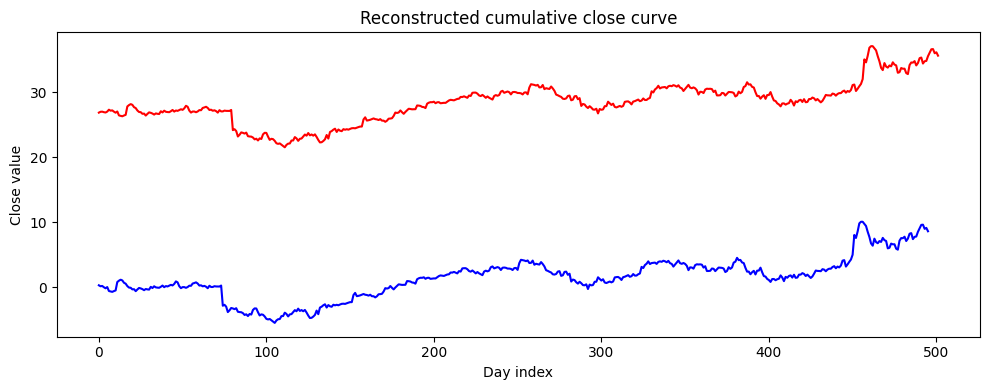

In [3]:
for sample, annotation in training_loader_1:
    print(sample)
    print(annotation)
    break

# Collect standardized targets
std_targets = []
for x, y in training_loader_1:
    std_targets.append(y.item())
std_targets = np.array(std_targets)

# Inverse z-score
inv = std_targets * training_dataset_1.get_zscore_params()[1] + training_dataset_1.get_zscore_params()[0]

# Reconstruct cumulative close curve
curve = np.cumsum(inv)

# Plot
plt.figure(figsize=(10,4))
plt.plot(curve, c="b")
plt.plot(X_train_1[:, 4], c="r")
plt.title("Reconstructed cumulative close curve")
plt.xlabel("Day index")
plt.ylabel("Close value")
plt.tight_layout()

# RNN model

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# --- RNN Model Definition ---
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x, h=None):
        out, h = self.rnn(x, h)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1), h

# --- Train RNN on first 2 years, test on 3rd year ---
years = np.arange(2006, 2018)
train_years = [years[0], years[1]]
test_year = [years[2]]

# Prepare data
history_length = 5
X_train, X_test = dataloader.split_by_year(train_years, test_year)
train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length)
test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Model, optimizer, loss
input_size = history_length + 1 + 22  # history + today_change + features
hidden_size = 64
num_layers = 2
model = SimpleRNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

# Train with persistent hidden state
model.train()
h = None
for epoch in tqdm(range(100)):
    for x, y in train_loader:
        x = x.view(x.size(0), 1, -1)
        optimizer.zero_grad()
        output, h = model(x, h)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        h = h.detach()

# Test with persistent hidden state
model.eval()
preds, targets = [], []
h = None
with torch.no_grad():
    for x, y in test_loader:
        x = x.view(x.size(0), 1, -1)
        output, h = model(x, h)
        preds.append(output.item())
        targets.append(y.item())
        h = h.detach()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:50<00:00,  1.70s/it]



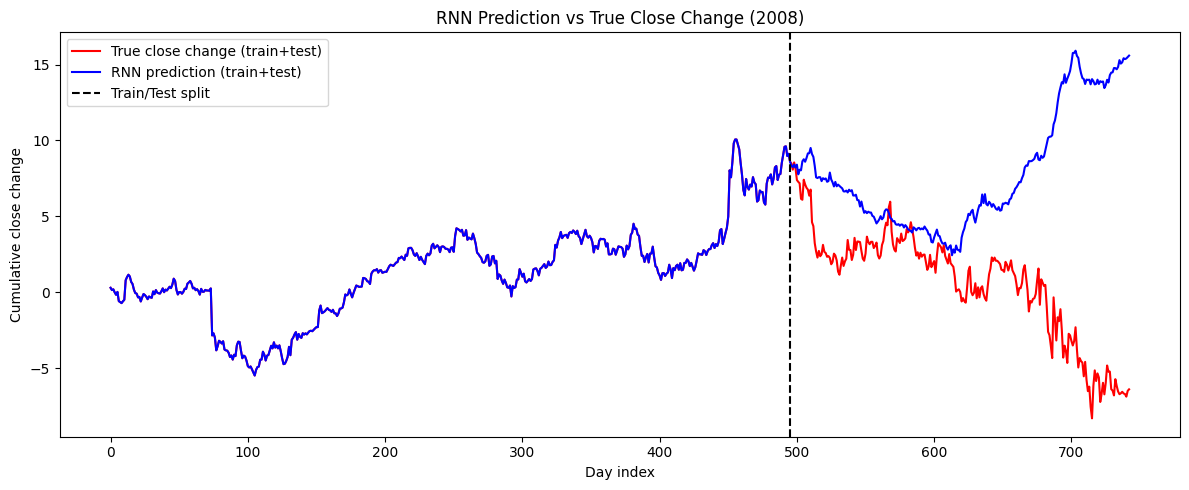

In [24]:
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y.item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv])
full_true = np.concatenate([train_targets_inv, np.array(targets) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="RNN prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"RNN Prediction vs True Close Change ({test_year[0]})")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()

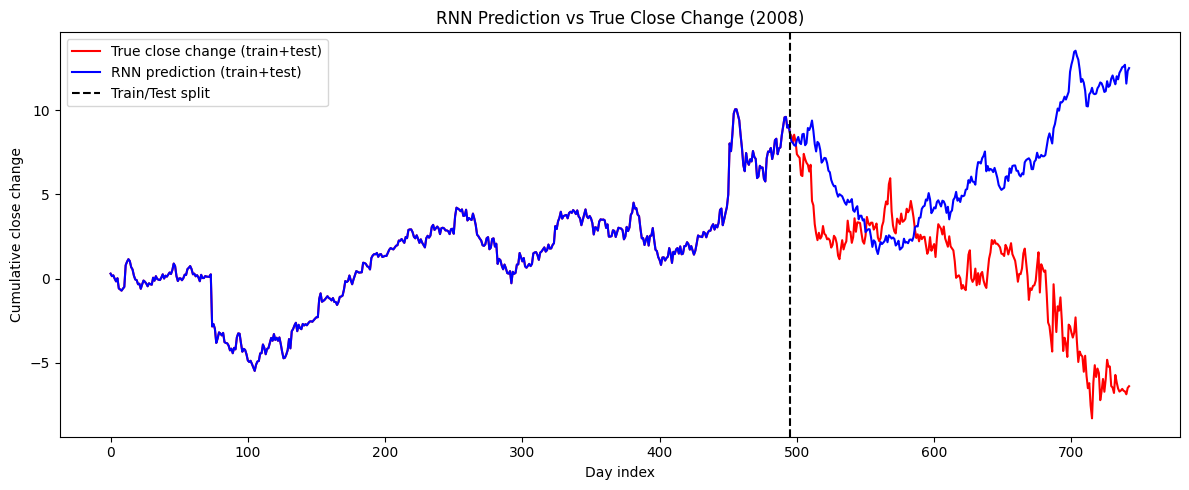

In [21]:
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y.item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv])
full_true = np.concatenate([train_targets_inv, np.array(targets) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="RNN prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"RNN Prediction vs True Close Change ({test_year[0]})")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()